In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy
import matplotlib.colors as mcolors
import networkx as nx
import pickle
import copy
from numba.typed import Dict
from numba.core import types
import networkx as nx

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_wc
from neurolib.control.optimal_control import cost_functions

import matplotlib as mpl
label_size= 20
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams['font.size'] = label_size
mpl.rcParams['axes.titlesize'] = label_size

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

while "Promotion/neurolib" in os.getcwd():
    os.chdir('..')

pickledir = os.path.join(os.getcwd(), "neurolib_aln_osc_datastorage/optimal_control/WP2/6n")
dir = pickledir

print(dir)

def plotspectrum(data, fmax=1., filename=None, vlines=None):

    ps_comp = None

    for d in data:
        ps = np.abs(np.fft.fft(d))
        ps_plot = ps[:int(len(ps)/2)] / (len(ps)/2)
        ps_plot[0] = 0.
        fr = np.linspace(0,1./(2.*dt),len(ps_plot))

        if ps_comp is None:
            ps_comp = ps_plot
        else:
            ps_comp += ps_plot

        plt.plot(fr, ps_plot)

    if vlines is not None:
        plt.vlines(vlines, 0, 1, color="gray", linestyle=":")

    plt.xlim(0,fmax)
    plt.ylim(0,1.3*np.amax(ps_plot))
    #plt.ylim(0,0.5)
    plt.tight_layout()

    if filename is not None:
        plt.savefig(os.path.join(dir, filename))
    
    plt.show()

    maxfreqind = np.where(ps_comp == max(ps_comp[1:]))
    print("freq of max = ", fr[maxfreqind])
    print("period of max = ", 1./fr[maxfreqind])

    return (1./fr[maxfreqind])[0]

def draw_nwgraph(cmat):
    G = nx.DiGraph() 
    for n in range(cmat.shape[0]):
            for l in range(cmat.shape[1]):
                if cmat[n,l] != 0:
                    G.add_edge(l,n)
    nx.draw(G, with_labels=True, arrows=True, **options)
    plt.show()

options = {
'node_color': 'lightgray',
'node_size': 1000,
'width': 2,
'arrowstyle': '-|>',
'arrowsize': 20,
'font_size' : 20,
'font_weight' : 'bold',
}

/home/lena/Promotion/neurolib_aln_osc_datastorage/optimal_control/WP2/6n


In [52]:
N = 6

cmat = np.zeros((N,N) )
dmat = np.zeros((N,N) )

p = 0.4

for n1 in range(N):
    for n2 in range(N):
        if n1 == n2: continue
        if np.random.rand() < p:
            cmat[n1,n2] = 1
            dmat[n1,n2] = int(np.random.rand() * 20)

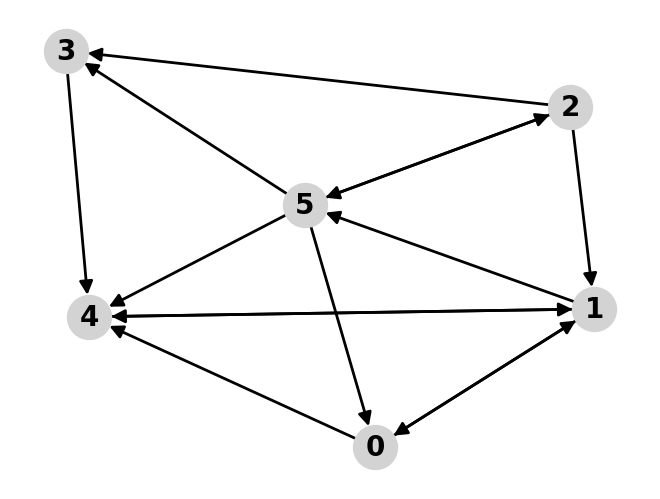

[[0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 1.]
 [1. 1. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 0.]]
[[ 0. 12.  0.  0.  0.  8.]
 [ 8.  0. 13.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  9.]
 [ 0.  0.  4.  0.  0. 11.]
 [ 5. 17.  0. 14.  0. 18.]
 [ 0.  0.  3.  0.  0.  0.]]


In [79]:
draw_nwgraph(cmat)

print(cmat)
print(dmat)

In [7]:
N = 6

cmat = np.array([[0., 1., 0., 0., 0., 1.],
 [1., 0., 1., 0., 1., 0.],
 [0., 0., 0., 0., 0., 1.],
 [0., 0., 1., 0., 0., 1.],
 [1., 1., 0., 1., 0., 1.],
 [0., 1., 1., 0., 0., 0.]])
dmat = np.array( [[ 0., 12.,  0.,  0.,  0.,  8.],
 [ 8.,  0., 13.,  0.,  1.,  0.],
 [ 0.,  0.,  0.,  0.,  0.,  9.],
 [ 0.,  0.,  4.,  0.,  0., 11.],
 [ 5., 17.,  0., 14.,  0., 18.],
 [ 0.,  0.,  3.,  0.,  0.,  0.]])

In [4]:
coupling_array = np.array( [0.4, 0.8] )

eext = np.arange(0., 3., 0.2)
iext = np.arange(0., 3., 0.2)

add_ind = 15000

In [15]:
### ASYNC STATE INITAL

eext = [1.6]
iext = [0.4]

data_sync = dict()

data_sync["control"] = [None, None, None]
data_sync["state"] = [None, None, None]
data_sync["init"] = [None, None]
data_sync["weights"] = np.ones((3))
data_sync["control_cost"] = np.zeros((3))
data_sync["sync_cost"] = np.zeros((3))

----------------------------------------------------------- 0
----------------------------------------------------------- 1
1.6 0.4


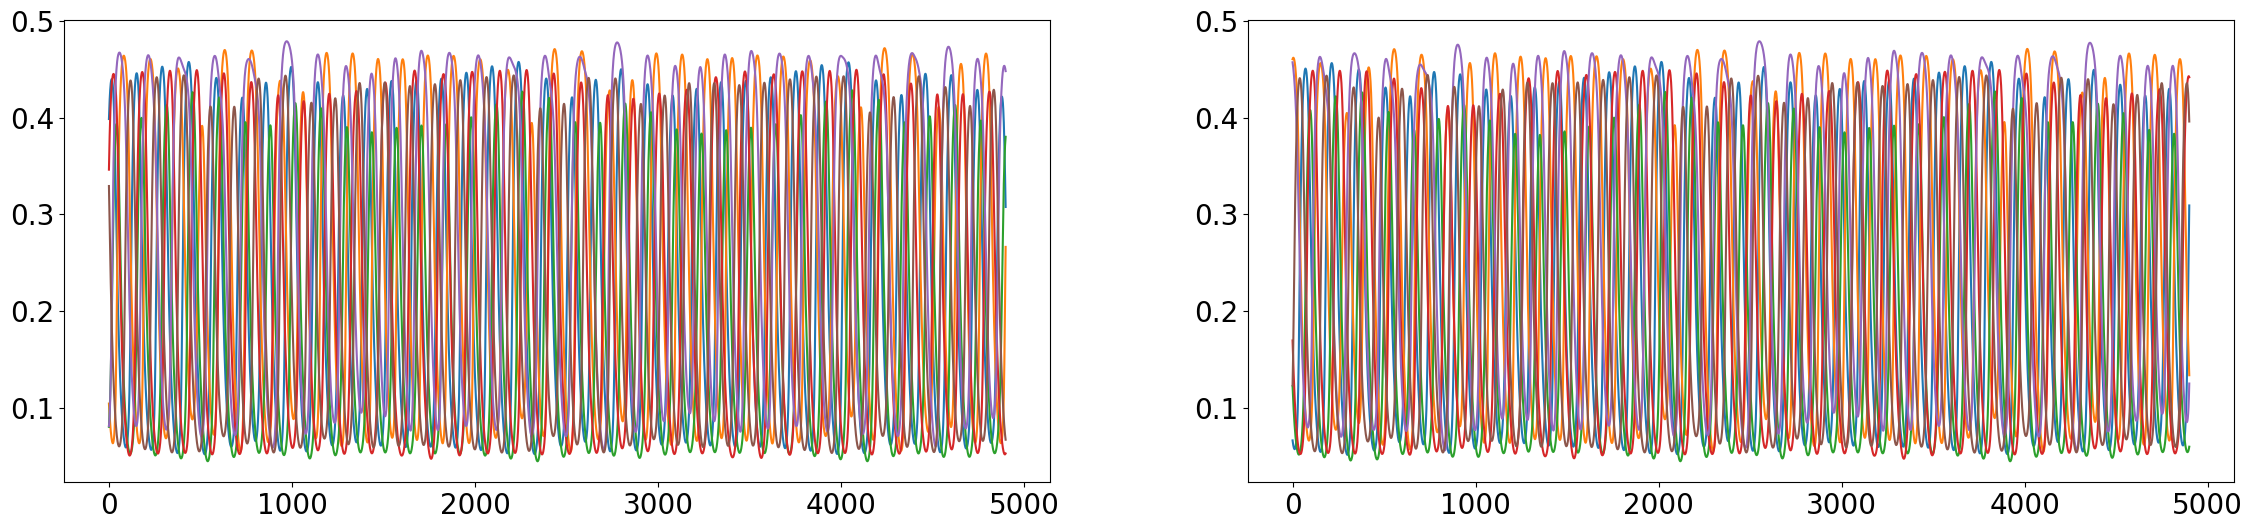

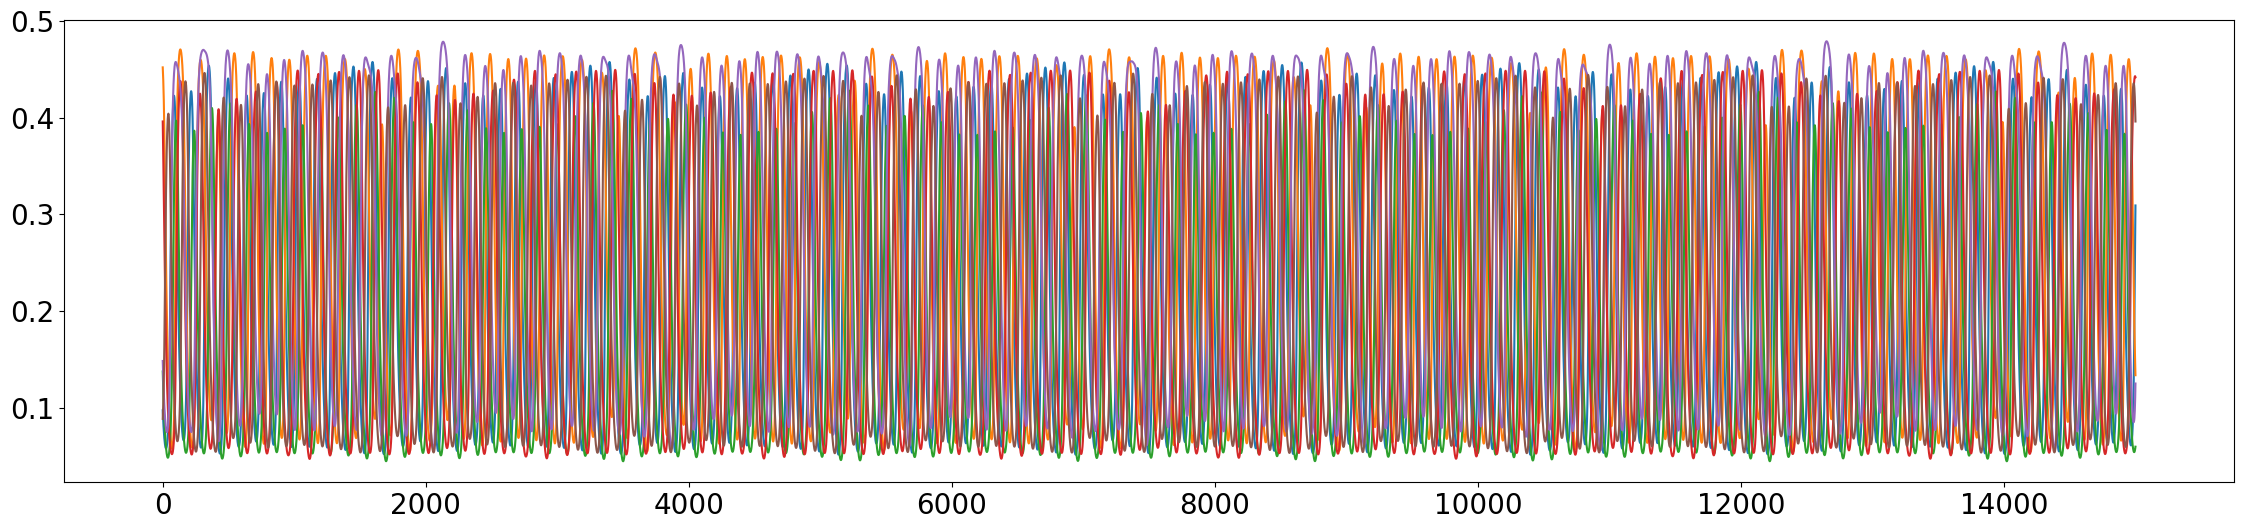

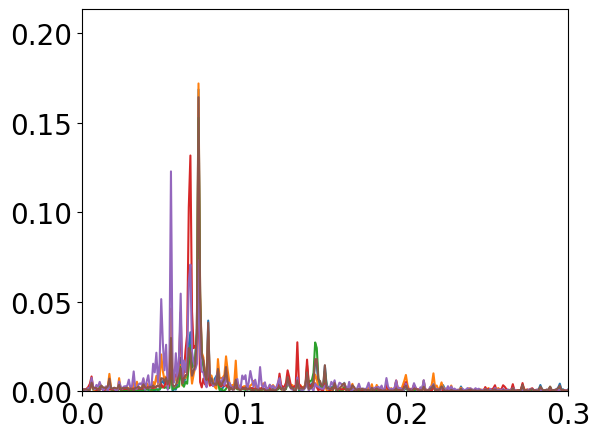

freq of max =  [0.0720144]
period of max =  [13.88611111]


In [16]:
for ci in range(len(coupling_array)):

    print("-----------------------------------------------------------", ci)

    if ci not in [1]: continue

    for e_ in eext:
        
        for i_ in iext:

            print(e_, i_)
        
            model = WCModel(Cmat=cmat, Dmat=dmat)
            model.params.K_gl = coupling_array[ci]
            dt = 0.1
            model.params.dt = dt

            dur = 4000.
            measure_dur = 30.
            i00, i01 = 0, 100
            i10, i11 = 20000, 20100

            model.params['duration'] = dur 
            test_input = ZeroInput().generate_input(duration=model.params['duration']+model.params.dt, dt=model.params.dt)
            test_input[:,i00:i01] = 6.
            test_input[:,i10:i11] = -6.
            model.params.exc_ext_baseline = e_
            model.params.inh_ext_baseline = i_
            model.params.exc_ext = test_input

            model.run()

            maxdelay = model.getMaxDelay()

            einit = np.zeros((N, maxdelay+1))
            iinit = np.zeros((N, maxdelay+1))

            for n in range(N):
                einit[n,:] = model.exc[n, -maxdelay-1:]
                iinit[n,:] = model.inh[n, -maxdelay-1:]

            data_sync["init"][0] = einit
            data_sync["init"][1] = iinit

            if np.var(model.exc[0,i01+add_ind:i10]) < 1e-6 and np.var(model.exc[0,i11+add_ind:]) < 1e-6:
                continue

            fig, ax = plt.subplots(1,2, figsize=(28,6))

            for n in range(N):
                ax[0].plot(model.exc[n,i01+add_ind:i10])
                ax[1].plot(model.exc[n,i11+add_ind:])

            plt.show()

            if True:

                fig, ax = plt.subplots(1,1, figsize=(28,6))
                for n in range(N):
                    ax.plot(model.exc[n,-add_ind:])
                plt.show()

                period_async = plotspectrum( [model.exc[0,-10000:], model.exc[1,-10000:], model.exc[2,-10000:], model.exc[3,-10000:], model.exc[4,-10000:], model.exc[5,-10000:]], fmax = 0.3)

In [17]:
### SYNC STATE INITAL

eext = [1.]
iext = [0.4]

data_desync = dict()

data_desync["control"] = [None, None, None]
data_desync["state"] = [None, None, None]
data_desync["init"] = [None, None]
data_desync["weights"] = np.ones((3))
data_desync["control_cost"] = np.zeros((3))
data_desync["sync_cost"] = np.zeros((3))

----------------------------------------------------------- 0
----------------------------------------------------------- 1
1.0 0.4


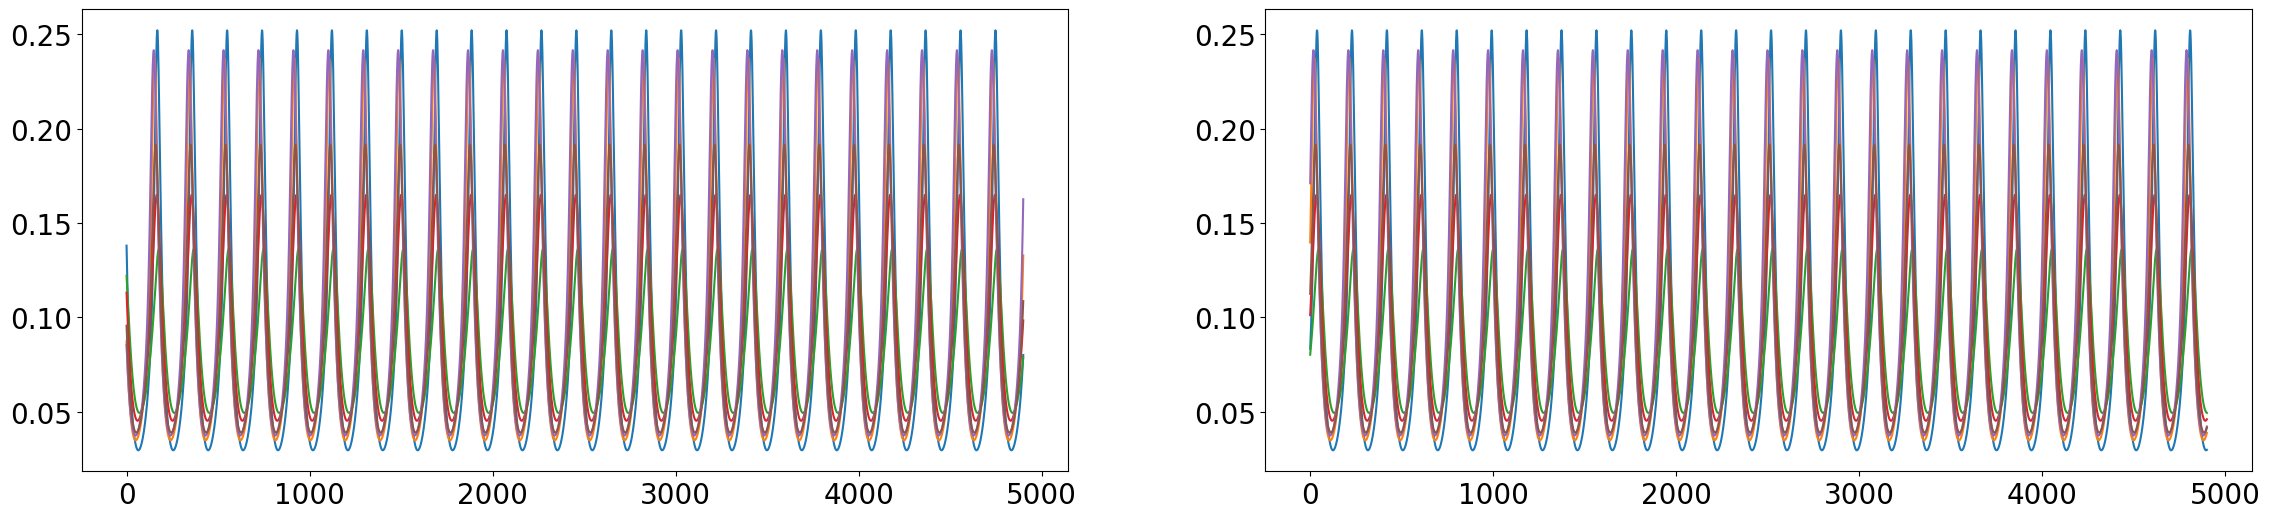

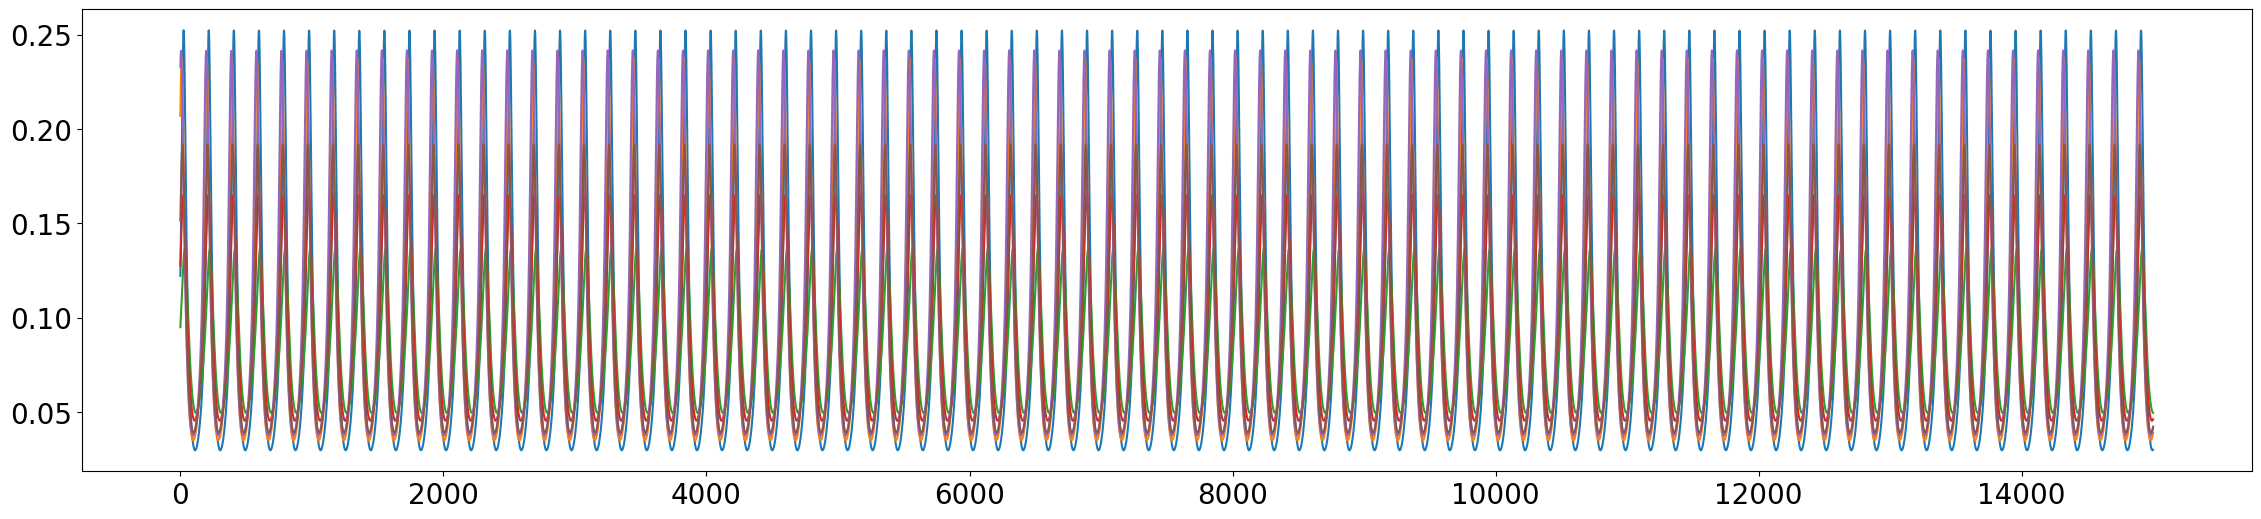

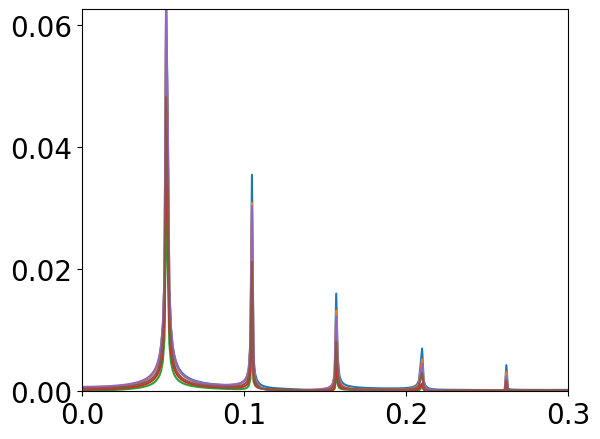

freq of max =  [0.0520104]
period of max =  [19.22692308]


In [32]:
for ci in range(len(coupling_array)):

    print("-----------------------------------------------------------", ci)

    if ci not in [1]: continue

    for e_ in eext:
        
        for i_ in iext:

            print(e_, i_)
        
            model = WCModel(Cmat=cmat, Dmat=dmat)
            model.params.K_gl = coupling_array[ci]
            dt = 0.1
            model.params.dt = dt

            dur = 4000.
            measure_dur = 30.
            i00, i01 = 0, 100
            i10, i11 = 20000, 20100

            model.params['duration'] = dur 
            test_input = ZeroInput().generate_input(duration=model.params['duration']+model.params.dt, dt=model.params.dt)
            test_input[:,i00:i01] = 6.
            test_input[:,i10:i11] = -6.
            model.params.exc_ext_baseline = e_
            model.params.inh_ext_baseline = i_
            model.params.exc_ext = test_input

            model.run()

            maxdelay = model.getMaxDelay()

            einit = np.zeros((N, maxdelay+1))
            iinit = np.zeros((N, maxdelay+1))

            for n in range(N):
                einit[n,:] = model.exc[n, -maxdelay-1:]
                iinit[n,:] = model.inh[n, -maxdelay-1:]

            data_desync["init"][0] = einit
            data_desync["init"][1] = iinit

            if np.var(model.exc[0,i01+add_ind:i10]) < 1e-6 and np.var(model.exc[0,i11+add_ind:]) < 1e-6:
                continue

            fig, ax = plt.subplots(1,2, figsize=(28,6))

            for n in range(N):
                ax[0].plot(model.exc[n,i01+add_ind:i10])
                ax[1].plot(model.exc[n,i11+add_ind:])

            plt.show()

            if True:

                fig, ax = plt.subplots(1,1, figsize=(28,6))
                for n in range(N):
                    ax.plot(model.exc[n,-add_ind:])
                plt.show()

                period_sync = plotspectrum( [model.exc[0,-10000:], model.exc[1,-10000:], model.exc[2,-10000:], model.exc[3,-10000:], model.exc[4,-10000:], model.exc[5,-10000:]], fmax = 0.3)

----------------------------------------------------------- 0
----------------------------------------------------------- 1
1.4 0.4


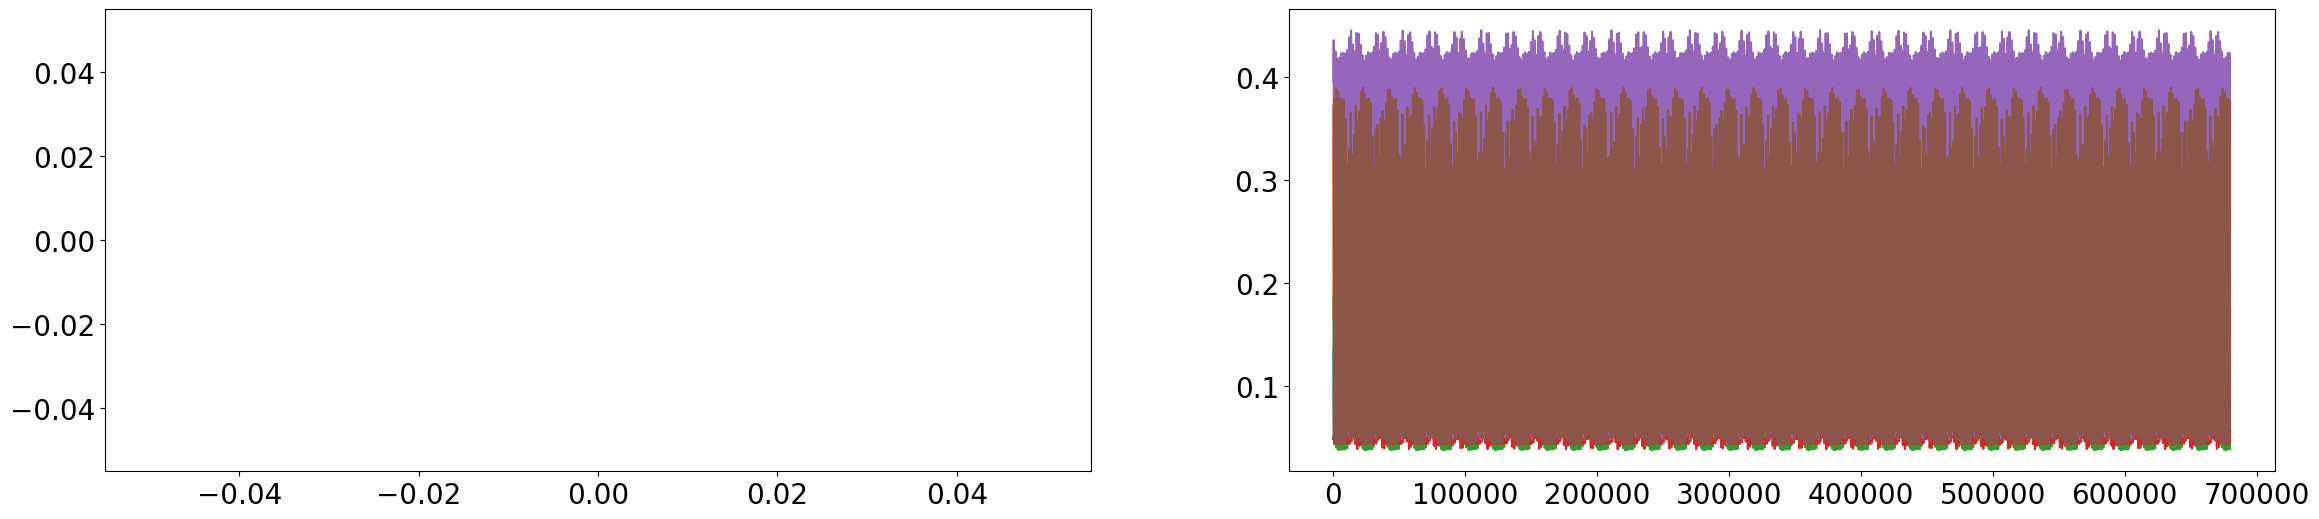

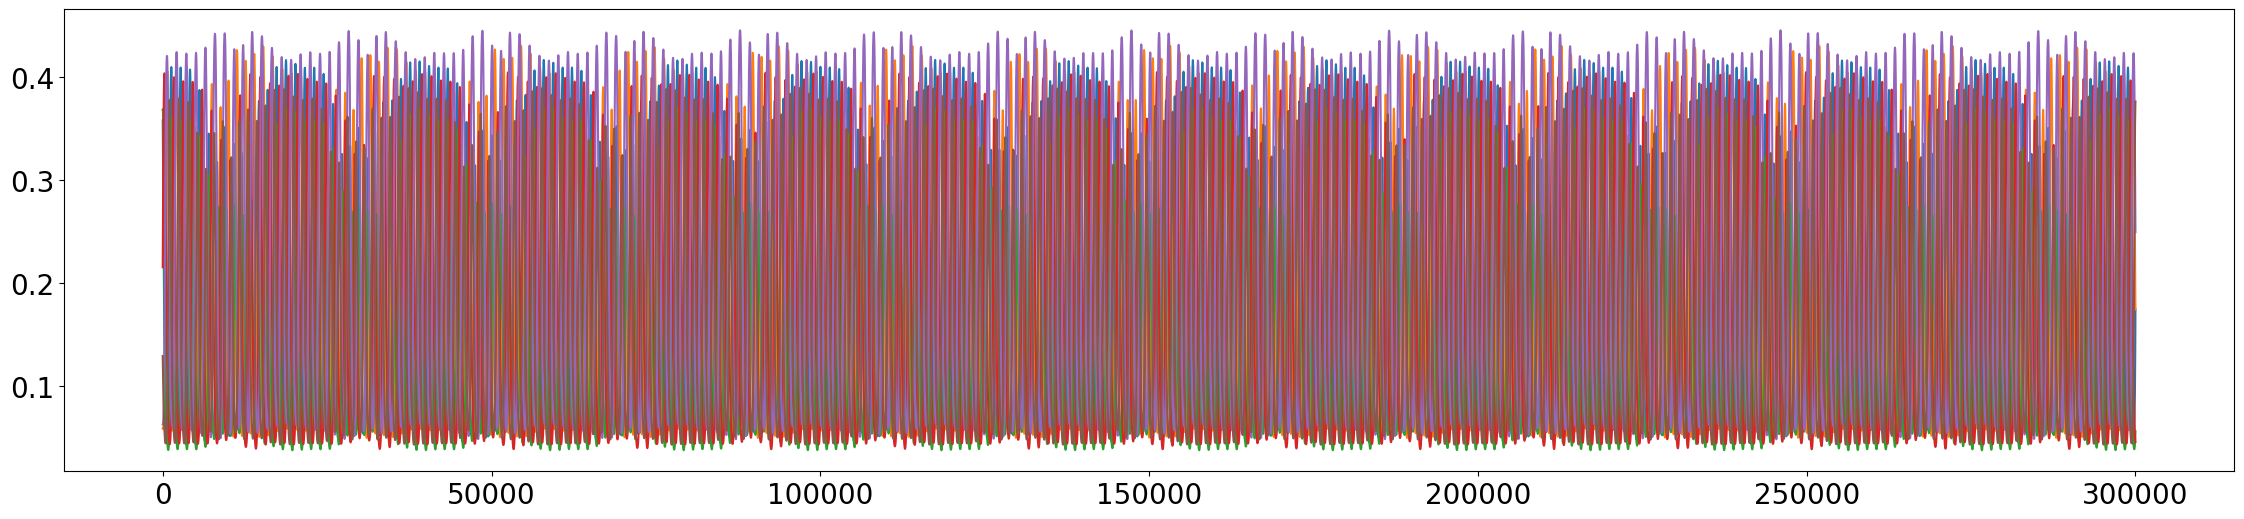

In [66]:
for ci in range(len(coupling_array)):

    print("-----------------------------------------------------------", ci)

    if ci not in [1]: continue

    for e_ in eext:
        
        for i_ in iext:

            print(e_, i_)
        
            model = WCModel(Cmat=cmat, Dmat=dmat)
            model.params.K_gl = coupling_array[ci]
            dt = 0.01
            model.params.dt = dt

            dur = 10000.

            model.params['duration'] = dur 
            test_input = ZeroInput().generate_input(duration=model.params['duration']+model.params.dt, dt=model.params.dt)
            model.params.exc_ext_baseline = e_
            model.params.inh_ext_baseline = i_

            model.run()

            add_ind = int(3000/dt)

            fig, ax = plt.subplots(1,2, figsize=(28,6))

            for n in range(N):
                ax[0].plot(model.exc[n,i01+add_ind:i10])
                ax[1].plot(model.exc[n,i11+add_ind:])
            plt.show()


            fig, ax = plt.subplots(1,1, figsize=(28,6))
            for n in range(N):
                ax.plot(model.exc[n,-add_ind:])
            plt.show()

In [20]:
weights = Dict.empty(
        key_type=types.unicode_type,
        value_type=types.float64,
    )

weights["w_2"] = 1.0
weights["w_1"] = 0.0
weights["w_1T"] = 0.0
weights["w_1D"] = 0.0

def optimize_model(model, exprange):
    for l in range(2):
        for k in exprange:
            model.zero_step_encountered = False
            model.step = 10**(k)
            model.optimize(it)
        model.control_matrix = controlmat
    model.zero_step_encountered = False

    return

In [21]:
controlmat = np.zeros((N,2))
controlmat[:,0] = 1

costmat = np.zeros((N,2))
costmat[:,0] = 1

duration = 800
control_interval = [1000, -2000]
cost_interval = [1000, -2000]

maxstr = 5
pr = np.arange(0,501,10)

zero_input0 = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
zero_control = np.vstack( ([zero_input]*N))

In [22]:
uncontrolled_state_sync = None
uncontrolled_cost_sync = np.zeros((3))

---------------------------------------  F
---------------------------------------  CC
---------------------------------------  VAR
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 9.992300330045264
Final cost : 9.992300330045264
Compute control for a deterministic system
Cost in iteration 0: 3.5349008767341785
Final cost : 3.5349008767341785
Compute control for a deterministic system
Cost in iteration 0: 3.5349008767341785
Converged in iteration 2 with cost 3.5349008767341785
Final cost : 3.5349008767341785
Compute control for a deterministic system
Cost in iteration 0: 3.5349008767341785
Converged in iteration 2 with cost 3.5349008767341785
Final cost : 3.5349008767341785
Compute control for a deterministic system
Cost in iteration 0: 3.5349008767341785
Converged in iteration 2 with cost 3.5349008767341785
Final cost : 3.5349008767341785
Compute control for a deterministic system
Cost in iteration 0: 3.5349008767341785
Con

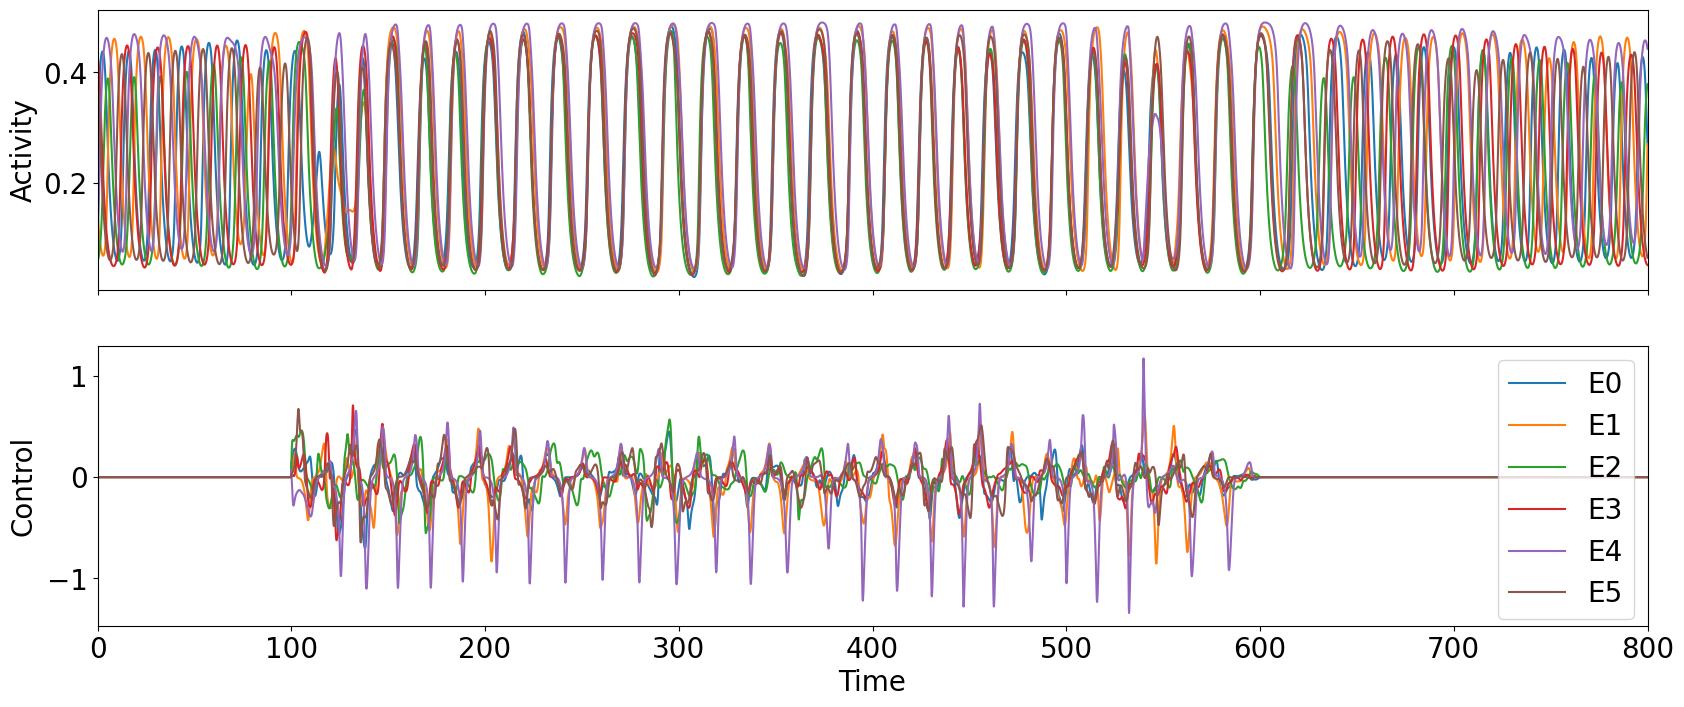

In [112]:
it = 1000

model = WCModel(Cmat=cmat, Dmat=dmat)
model.params.K_gl = coupling_array[1]
dt = 0.1
model.params.dt = dt

model.params['duration'] = duration
model.params.exc_ext_baseline = 1.6
model.params.inh_ext_baseline = 0.4

model.params["exc_ext"] = zero_control[:,0,:]
model.params["inh_ext"] = zero_control[:,1,:]

model.params["exc_init"] = data_sync["init"][0]
model.params["inh_init"] = data_sync["init"][1]

model.run()

uncontrolled_state_sync = [model.exc, model.inh]

for mi, method in enumerate(["F", "CC", "VAR"]):

    print("--------------------------------------- ", method)

    if mi not in [2]: continue

    #data_sync["weights"][mi] = 0.0025

    model_controlled = oc_wc.OcWc(model, period_async, print_array=pr, cost_interval=cost_interval, control_interval=control_interval,
                                cost_matrix=costmat, control_matrix=controlmat)
    
    model_controlled.weights["w_p"] = 0.
    model_controlled.weights["w_2"] = data_sync["weights"][mi]
    if method == "F":
        model_controlled.weights["w_f_sync"] = 1.
    elif method == "CC":
        model_controlled.weights["w_cc"] = 1.
    elif method == "VAR":
        model_controlled.weights["w_var"] = 1.

    model_controlled.maximum_control_strength = maxstr

    model_controlled.optimize(0)
    uncontrolled_cost_sync[mi] = model_controlled.cost_history[-1]

    if True:
        if type(data_sync["control"][mi]) != type(None):
            model_controlled.control = data_sync["control"][mi].copy()
            model_controlled.update_input()

    model_controlled.optimize(0)

    for j in range(1):
        model_controlled.grad_method = 0
        model_controlled.channelwise_optimization = True

        for l in range(1):
            for k in np.arange(0., 7., 2.):
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**(k)
                model_controlled.optimize(it)

        model_controlled.grad_method = 1
        model_controlled.channelwise_optimization = True

        for l in range(1):
            for k in np.arange(-5., 6., 2.):
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**(k)
                model_controlled.optimize(10)

    print("gradient = ", np.amax(np.abs(model_controlled.gradient)))

    data_sync["control"][mi] = model_controlled.control.copy()
    data_sync["state"][mi] = model_controlled.get_xs()

    coc = cost_functions.control_strength_cost(data_sync["control"][mi], weights, dt)
    data_sync["control_cost"][mi] = coc
    data_sync["sync_cost"][mi] = model_controlled.cost_history[-1] - data_sync["weights"][mi] * coc

    print("cost of control = ", coc)
    print("cost sync = ", data_sync["sync_cost"][mi])
    plot_control(data_sync["control"][mi], data_sync["state"][mi], duration, dt)
    #plot_control(plot_c[:,:,1:], plot_s, mod.params.duration-dt, dt)

    with open(os.path.join(pickledir, '6n_sync.pickle'), 'wb') as f:
        pickle.dump(data_sync, f)

In [ ]:
with open(os.path.join(pickledir, '6n_sync.pickle'), 'rb') as f:
    res_read = pickle.load(f)
    print(res_read.keys() )

data_sync = res_read.copy()

In [28]:
uncontrolled_state_desync = None
uncontrolled_cost_desync = np.zeros((3))

---------------------------------------  F
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 0.0345147473953685
Final cost : 0.0345147473953685
Compute control for a deterministic system
Cost in iteration 0: 1.0291539558391032e-06
Final cost : 1.0291539558391032e-06
Compute control for a deterministic system
Cost in iteration 0: 1.0291539558391032e-06
Cost in iteration 10: 1.0291539084385137e-06
Converged in iteration 13 with cost 1.029153908438513e-06
Final cost : 1.029153908438513e-06
Compute control for a deterministic system
Cost in iteration 0: 1.029153908438513e-06
Converged in iteration 4 with cost 1.0291539080042886e-06
Final cost : 1.0291539080042886e-06
Compute control for a deterministic system
Cost in iteration 0: 1.0291539080042886e-06
Converged in iteration 2 with cost 1.0291539080042886e-06
Final cost : 1.0291539080042886e-06
Compute control for a deterministic system
Cost in iteration 0: 1.0291539080042886e-06

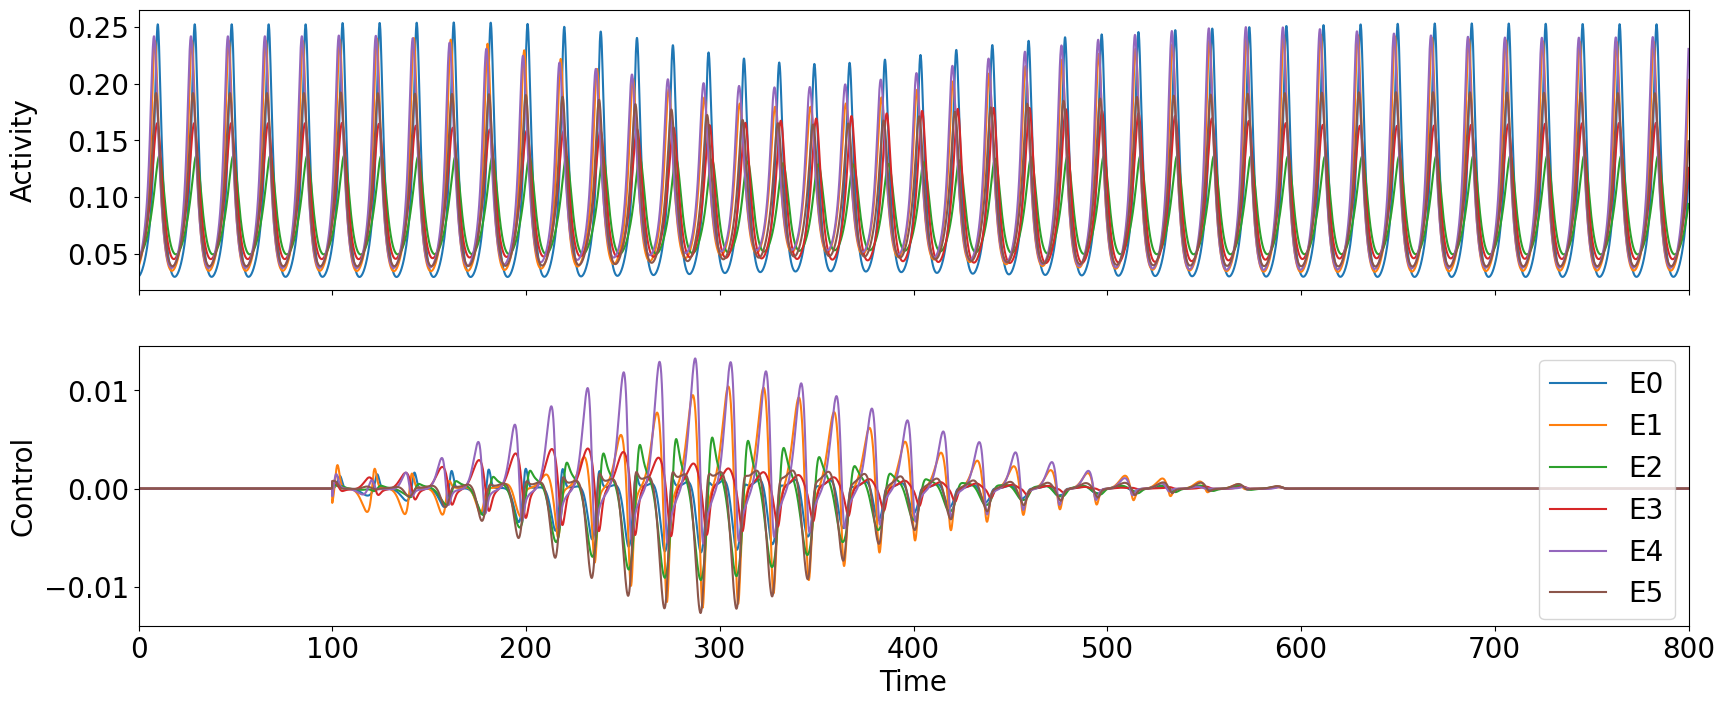

---------------------------------------  CC
---------------------------------------  VAR


In [143]:
it = 1000

model = WCModel(Cmat=cmat, Dmat=dmat)
model.params.K_gl = coupling_array[1]
dt = 0.1
model.params.dt = dt

model.params['duration'] = duration
model.params.exc_ext_baseline = 1.
model.params.inh_ext_baseline = 0.4

model.params["exc_ext"] = zero_control[:,0,:]
model.params["inh_ext"] = zero_control[:,1,:]

model.params["exc_init"] = data_desync["init"][0]
model.params["inh_init"] = data_desync["init"][1]

model.run()

uncontrolled_state_desync = [model.exc, model.inh]

for mi, method in enumerate(["F", "CC", "VAR"]):

    print("--------------------------------------- ", method)

    if mi not in [0]: continue

    #data_desync["weights"][mi] = 0.0001

    model_controlled = oc_wc.OcWc(model, period_sync, print_array=pr, cost_interval=cost_interval, control_interval=control_interval,
                                cost_matrix=costmat, control_matrix=controlmat)
    
    model_controlled.weights["w_p"] = 0.
    model_controlled.weights["w_2"] = data_desync["weights"][mi]
    if method == "F":
        model_controlled.weights["w_f_sync"] = -1.
    elif method == "CC":
        model_controlled.weights["w_cc"] = -1.
    elif method == "VAR":
        model_controlled.weights["w_var"] = -1.

    model_controlled.maximum_control_strength = maxstr

    model_controlled.optimize(0)
    uncontrolled_cost_desync[mi] = model_controlled.cost_history[-1]

    if True:
        if type(data_desync["control"][mi]) != type(None):
            model_controlled.control = data_desync["control"][mi].copy()
            model_controlled.update_input()

    model_controlled.optimize(0)

    for j in range(1):
        model_controlled.grad_method = 0
        model_controlled.channelwise_optimization = True

        for l in range(1):
            for k in np.arange(-3., 6., 2.):
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**(k)
                model_controlled.optimize(it)

        model_controlled.grad_method = 1
        model_controlled.channelwise_optimization = True

        for l in range(1):
            for k in np.arange(-4., 5., 2.):
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**(k)
                model_controlled.optimize(10)

    print("gradient = ", np.amax(np.abs(model_controlled.gradient)))

    data_desync["control"][mi] = model_controlled.control.copy()
    data_desync["state"][mi] = model_controlled.get_xs()

    coc = cost_functions.control_strength_cost(data_desync["control"][mi], weights, dt)
    data_desync["control_cost"][mi] = coc
    data_desync["sync_cost"][mi] = model_controlled.cost_history[-1] - data_desync["weights"][mi] * coc

    print("cost of control = ", coc)
    print("cost sync = ", data_desync["sync_cost"][mi])
    plot_control(data_desync["control"][mi], data_desync["state"][mi], duration, dt)
    #plot_control(plot_c[:,:,1:], plot_s, mod.params.duration-dt, dt)

    with open(os.path.join(pickledir, '6n_desync.pickle'), 'wb') as f:
        pickle.dump(data_desync, f)

In [23]:
with open(os.path.join(pickledir, '6n_desync.pickle'), 'rb') as f:
    res_read = pickle.load(f)
    print(res_read.keys() )

data_desync = res_read.copy()

dict_keys(['control', 'state', 'init', 'weights', 'control_cost', 'sync_cost'])


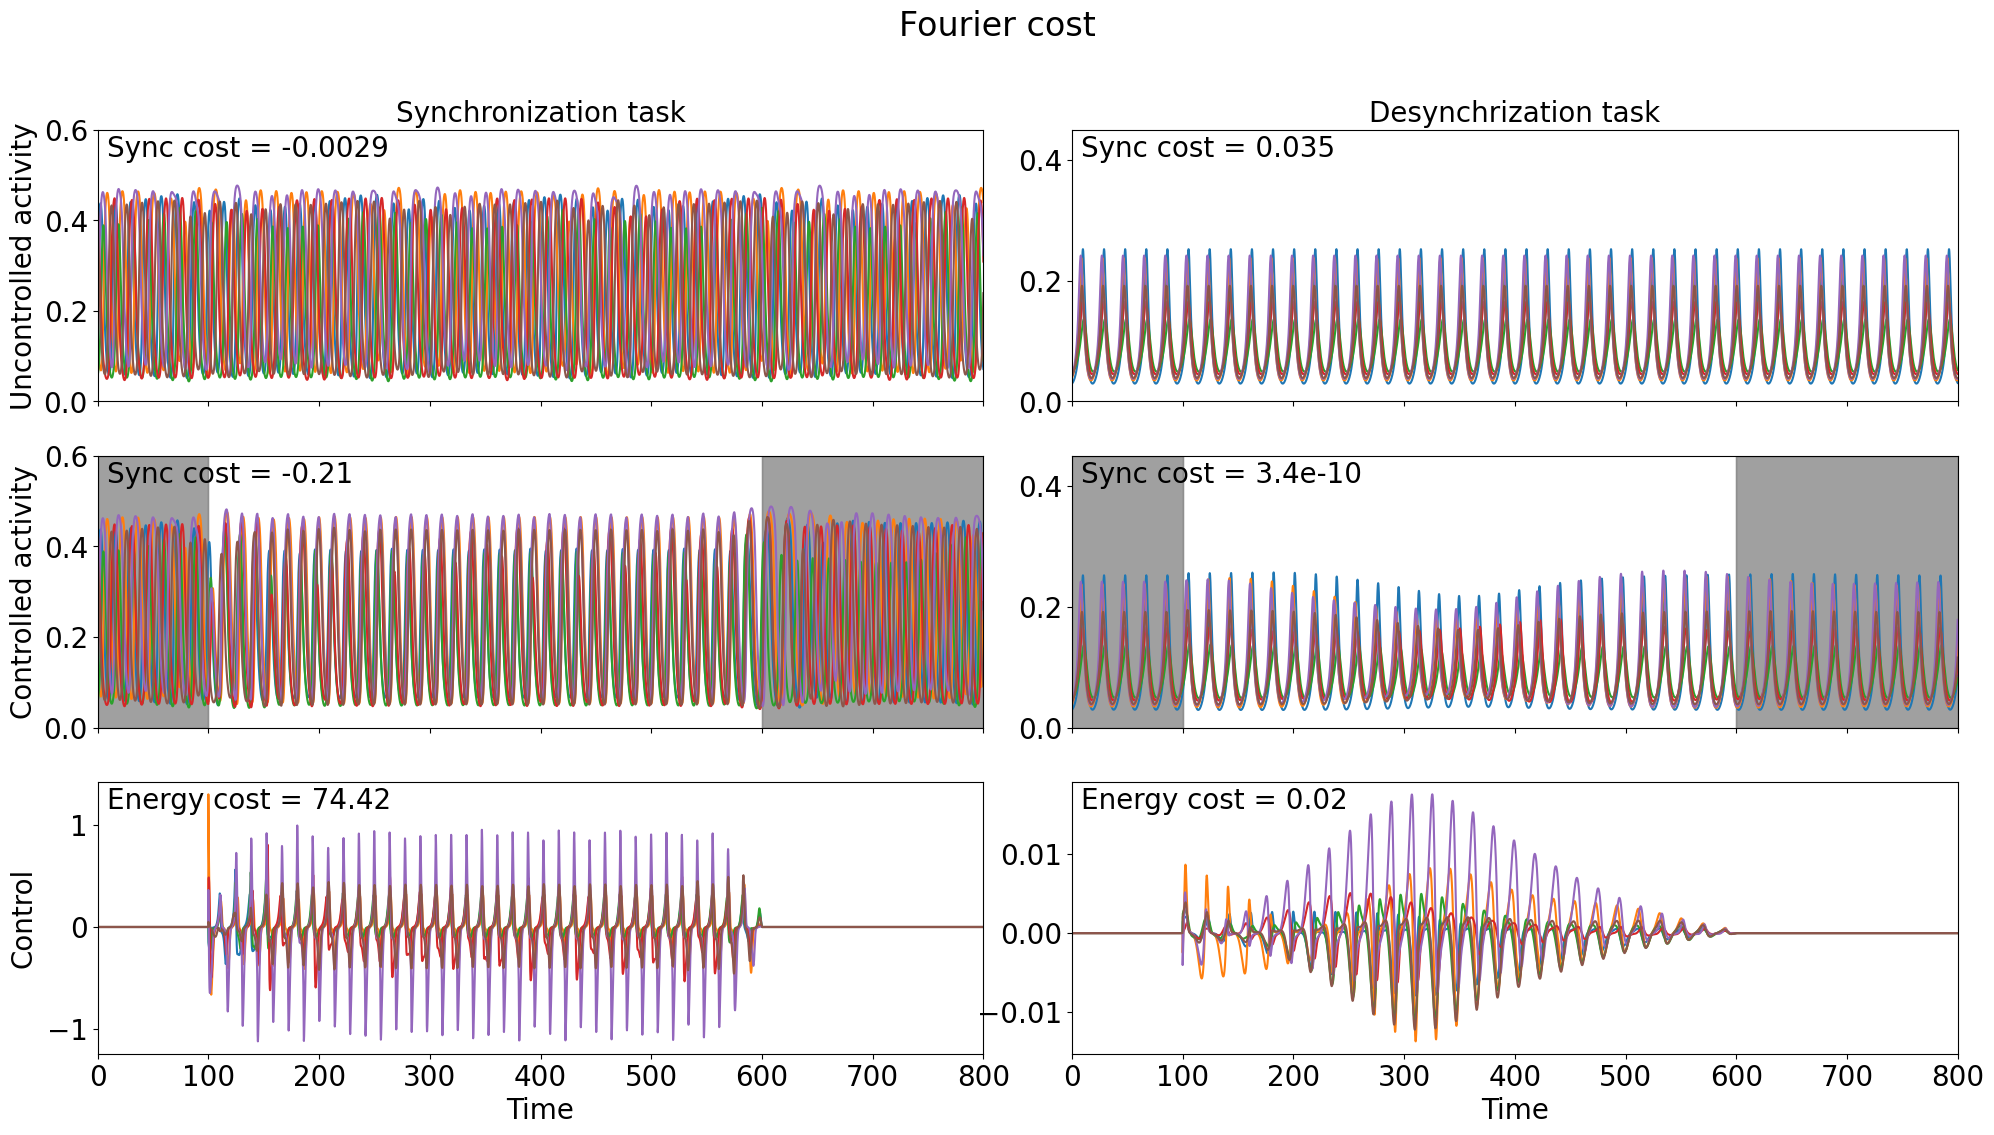

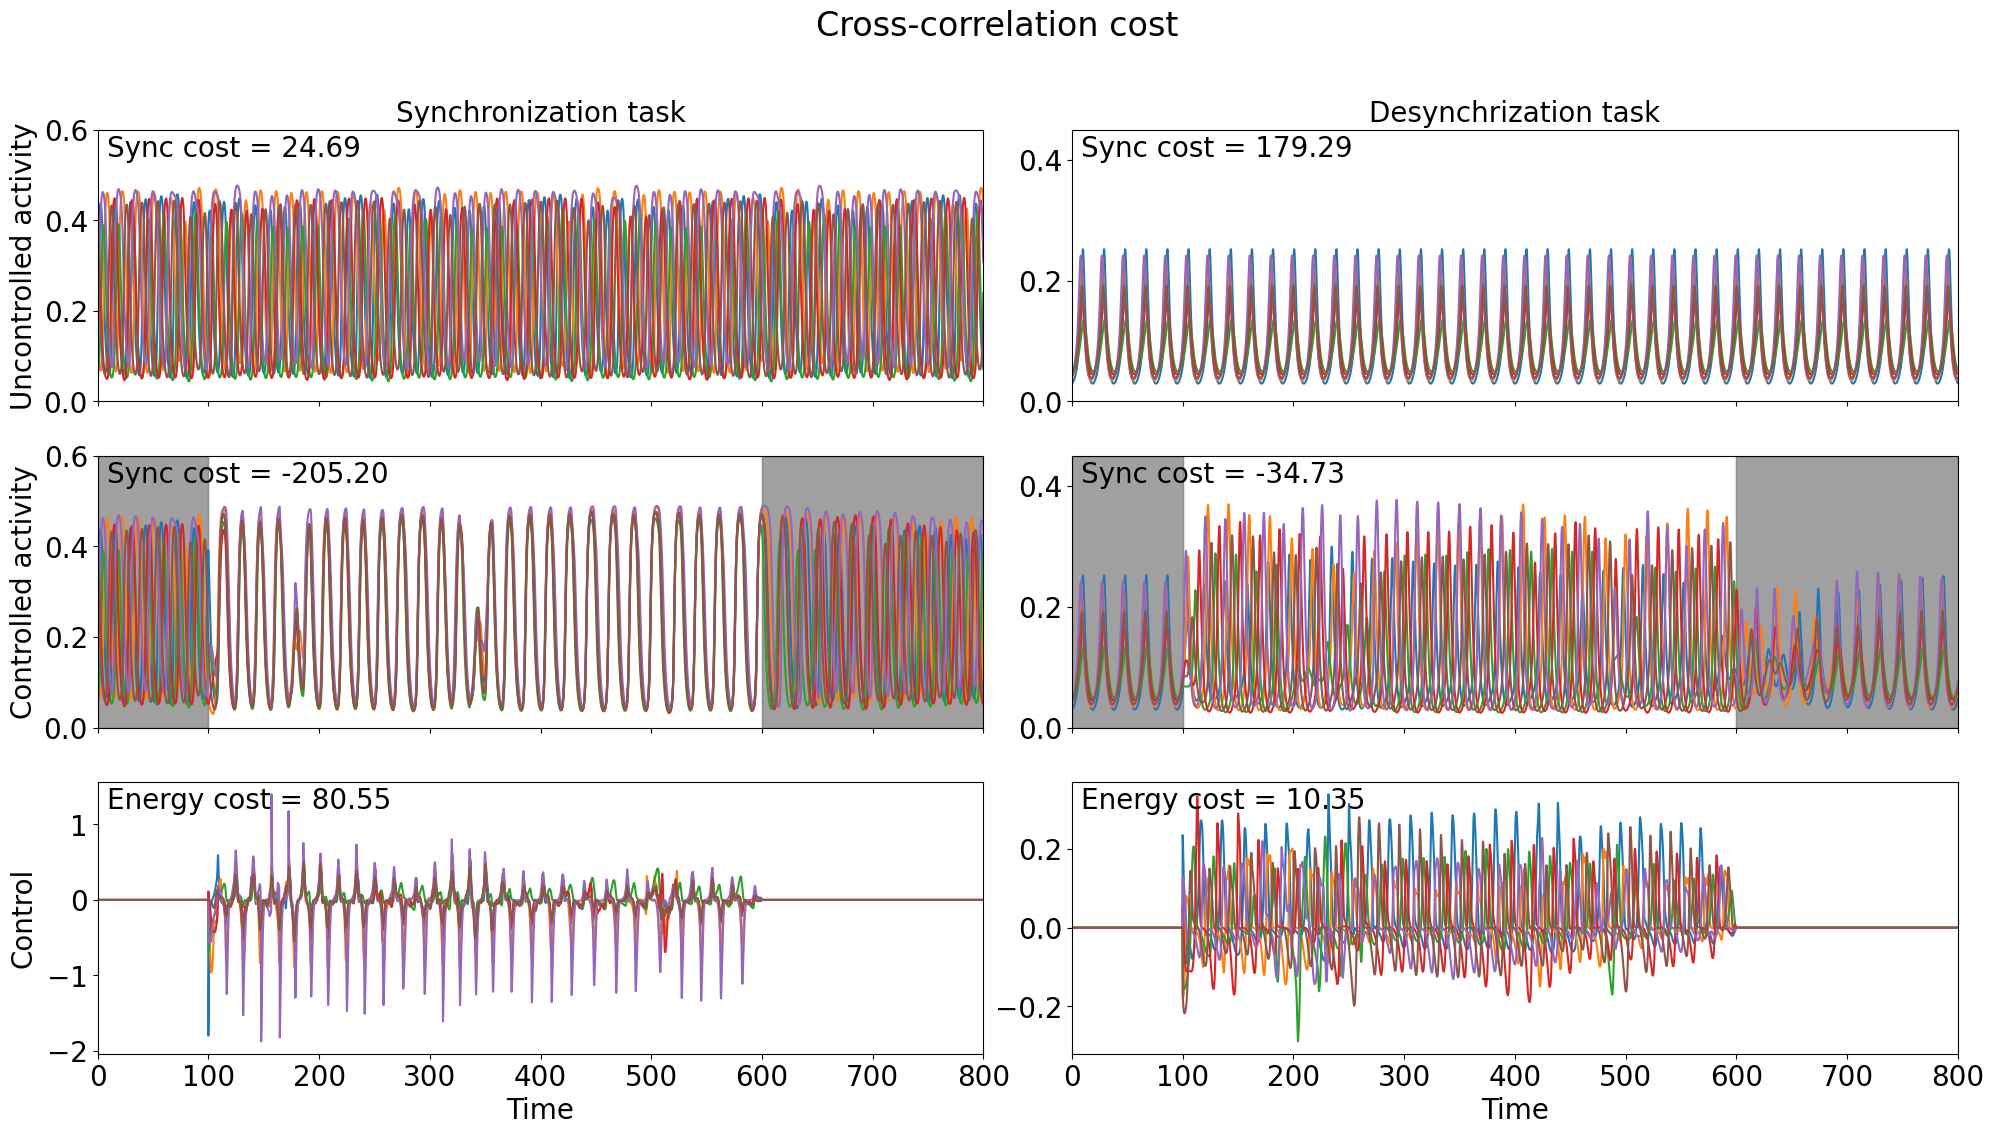

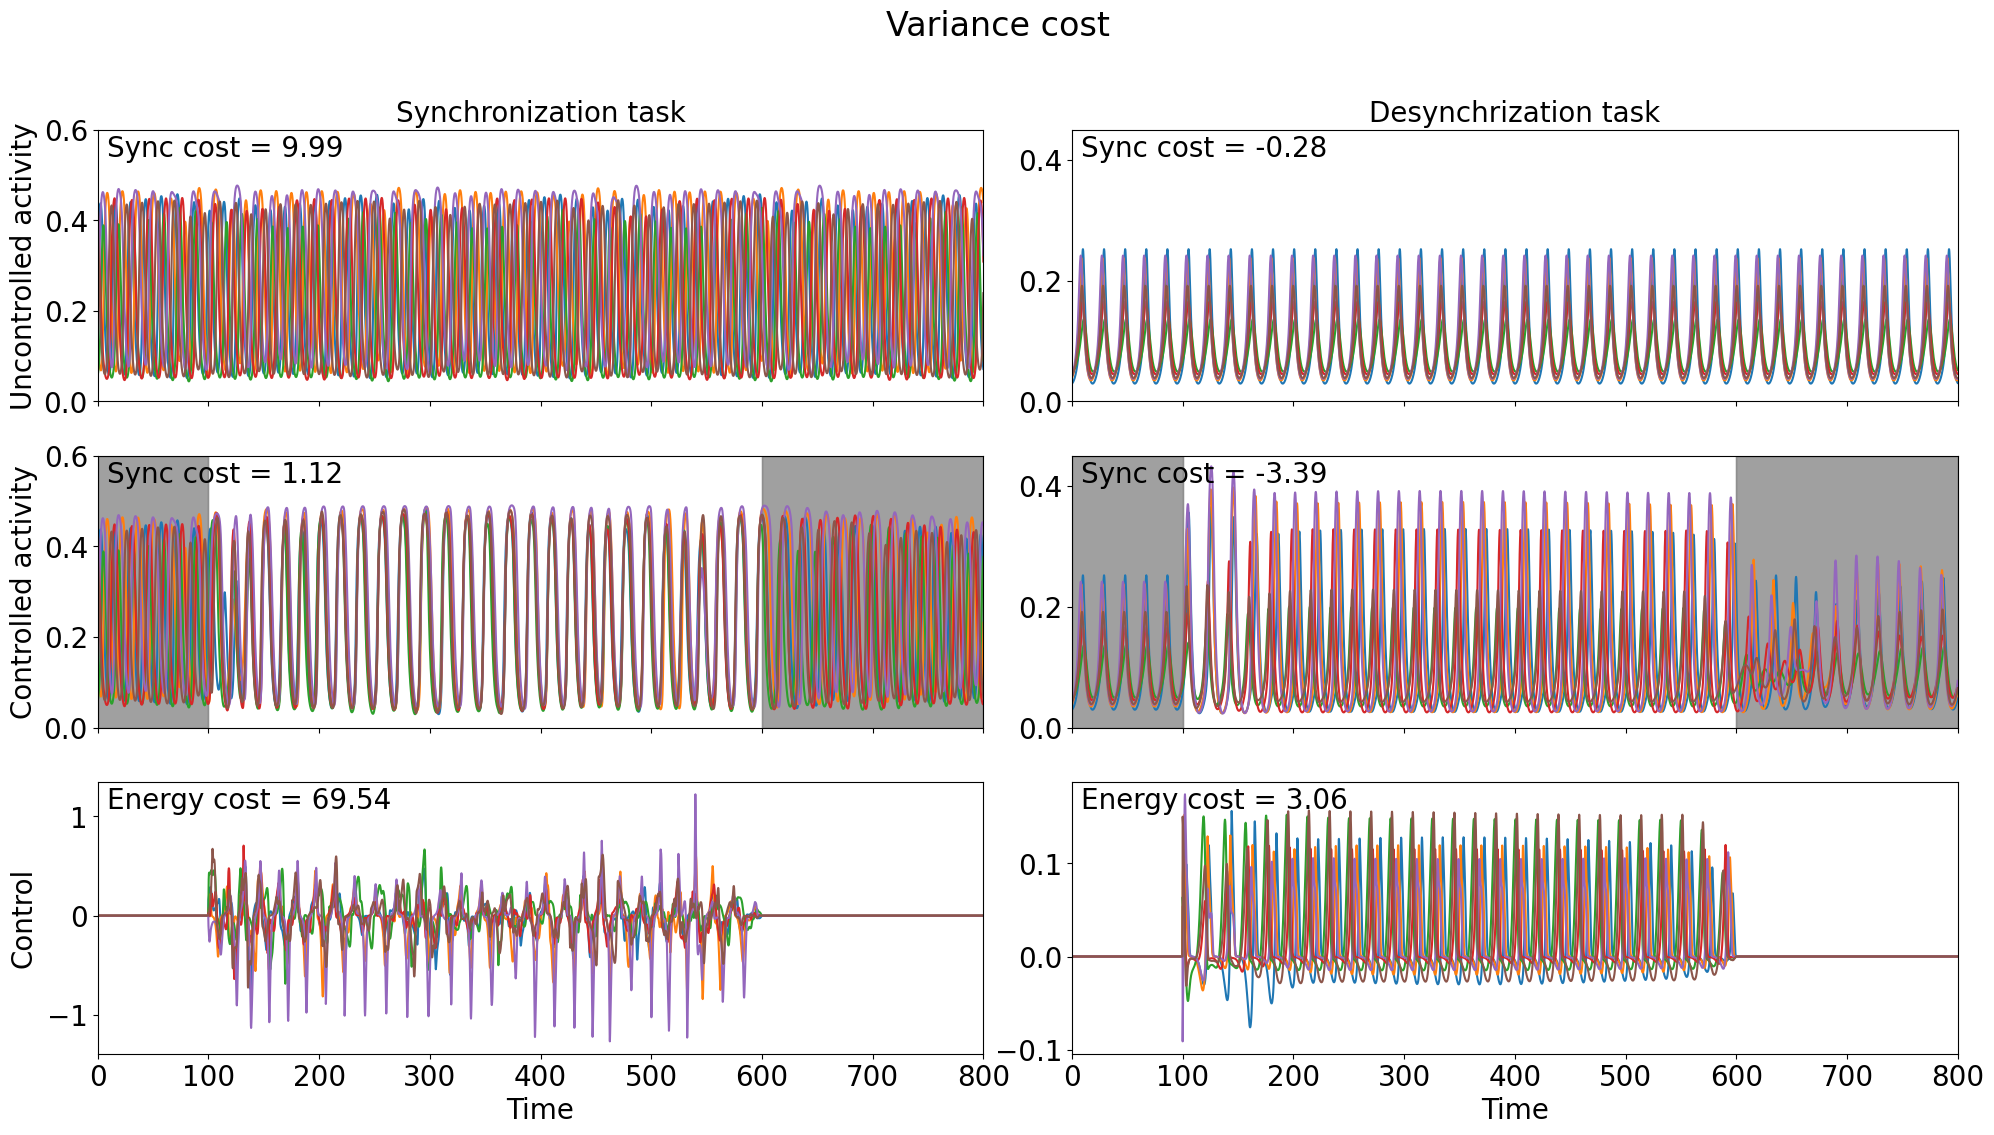

In [85]:
for mi in range(3):

    fig, ax = plt.subplots(3, 2, figsize=(24,12), sharex=True)

    time = np.arange(0, duration+dt, dt)

    for n in range(N):
        ax[0,0].plot(time[1:], uncontrolled_state_sync[0][n,:])
        ax[0,1].plot(time[1:], uncontrolled_state_desync[0][n,:])
        ax[1,0].plot(time, data_sync["state"][mi][n,0,:])
        ax[1,1].plot(time, data_desync["state"][mi][n,0,:])
        ax[2,0].plot(time, data_sync["control"][mi][n,0,:])
        ax[2,1].plot(time, data_desync["control"][mi][n,0,:])

        ax[1,0].axvspan(0, 100, color="grey", alpha=0.2)
        ax[1,0].axvspan(600, 800, color="grey", alpha=0.2)
        ax[1,1].axvspan(0, 100, color="grey", alpha=0.2)
        ax[1,1].axvspan(600, 800, color="grey", alpha=0.2)

    ax[0,0].set_title("Synchronization task")
    ax[0,1].set_title("Desynchrization task")

    xpos = 0.01
    ypos = 0.9

    if mi != 0:
        ax[0,0].text(xpos, ypos, "Sync cost = {0:.2f}".format(uncontrolled_cost_sync[mi]), transform=ax[0,0].transAxes)
        ax[0,1].text(xpos, ypos, "Sync cost = {0:.2f}".format(uncontrolled_cost_desync[mi]), transform=ax[0,1].transAxes)

        ax[1,0].text(xpos, ypos, "Sync cost = {0:0.2f}".format(data_sync["sync_cost"][mi]), transform=ax[1,0].transAxes)
        ax[1,1].text(xpos, ypos, "Sync cost = {0:0.2f}".format(data_desync["sync_cost"][mi]), transform=ax[1,1].transAxes)

    else:
        ax[0,0].text(xpos, ypos, "Sync cost = {0:.2g}".format(uncontrolled_cost_sync[mi]), transform=ax[0,0].transAxes)
        ax[0,1].text(xpos, ypos, "Sync cost = {0:.2g}".format(uncontrolled_cost_desync[mi]), transform=ax[0,1].transAxes)

        ax[1,0].text(xpos, ypos, "Sync cost = {0:0.2g}".format(data_sync["sync_cost"][mi]), transform=ax[1,0].transAxes)
        ax[1,1].text(xpos, ypos, "Sync cost = {0:0.2g}".format(data_desync["sync_cost"][mi]), transform=ax[1,1].transAxes)
        
    ax[2,0].text(xpos, ypos, "Energy cost = {:0.2f}".format(data_sync["control_cost"][mi]), transform=ax[2,0].transAxes)
    ax[2,1].text(xpos, ypos, "Energy cost = {:0.2f}".format(data_desync["control_cost"][mi]), transform=ax[2,1].transAxes)

    ax[0,0].set_ylim(0,0.6)
    ax[1,0].set_ylim(0,0.6)
    ax[0,1].set_ylim(0,0.45)
    ax[1,1].set_ylim(0,0.45)

    ax[0,0].set_xlim(0,duration)
    ax[2,0].set_xlabel("Time")
    ax[2,1].set_xlabel("Time")

    ax[0,0].set_ylabel("Uncontrolled activity")
    ax[1,0].set_ylabel("Controlled activity")
    ax[2,0].set_ylabel("Control")

    fig.align_ylabels([ax[:,0]])


    if mi == 0:
        fig.suptitle("Fourier cost")
    elif mi == 1:
        fig.suptitle("Cross-correlation cost")
    elif mi == 2:
        fig.suptitle("Variance cost")

    plt.subplots_adjust(wspace=0.1, 
                        hspace=0.2)

    plt.savefig(os.path.join(dir, "sync_desync" + str(mi) + ".pdf"), bbox_inches='tight')
    plt.show()



In [25]:
def plot_control(c, s, dur, dt):
    if dur < 1000:
        y1lim = [1.1 * np.amin(c[:,:,1:]), 1.1 * np.amax(c[:,:,1:])]
        fig, ax = plt.subplots(2,1, figsize=(20,8), sharex=True)
    else:
        y1lim = [1.1 * np.amin(c), 1.1 * np.amax(c)]
        fig, ax = plt.subplots(2,1, figsize=(28,8))

    time_array = np.arange(0, dur+dt, dt)

    for n in range(N):
        ax[0].plot(time_array,s[n,0,:], label="E{}".format(n))
        ax[1].plot(time_array, c[n,0,:], label="E{}".format(n))

    #ax[0].legend(loc="lower right")
    ax[1].legend(loc="upper right")

    ax[0].set_xlim(0, dur)
    ax[1].set_xlim(0, dur)
    #ax[0].set_ylim(y0lim)
    #ax[1].set_ylim(y1lim)

    ax[1].set_xlabel("Time")
    ax[0].set_ylabel("Activity")
    ax[1].set_ylabel("Control")
    
    fig.align_ylabels([ax[:]])


    plt.show()
    return